In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

import os, sys, random, itertools, codecs
import json
import re
import tarfile
import tempfile
import numpy as np
import keras
import keras.backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import merge, recurrent, Dense, Input, Dropout, TimeDistributed
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.layers.wrappers import Bidirectional
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.regularizers import l2
from keras.utils import np_utils

In [3]:
#extracting data
def extract_tokens_from_binary_parse(parse):
    return parse.replace('(', ' ').replace(')', ' ').replace('-LRB-', '(').replace('-RRB-', ')').split()

def yield_examples(fn, skip_no_majority=True, limit=None):
      for i, line in enumerate(codecs.open(fn, encoding='utf-8')):
        if limit and i > limit: break
        data = json.loads(line)
        label = data['gold_label']
        s1 = ' '.join(extract_tokens_from_binary_parse(data['sentence1_binary_parse']))
        s2 = ' '.join(extract_tokens_from_binary_parse(data['sentence2_binary_parse']))
        if skip_no_majority and label == '-': continue
        yield (label, s1, s2)

def get_data(fn, limit=None):
    fn = os.path.join('snli/snli_1.0',fn)
    raw_data = list(yield_examples(fn=fn, limit=limit))
    left = [s1 for _, s1, s2 in raw_data]
    right = [s2 for _, s1, s2 in raw_data]
    print(max(len(x.split()) for x in left))
    print(max(len(x.split()) for x in right))

    LABELS = {'contradiction': 0, 'neutral': 1, 'entailment': 2}
    Y = np.array([LABELS[l] for l, s1, s2 in raw_data])
    Y = np_utils.to_categorical(Y, len(LABELS))

    return left, right, Y

In [14]:
training = get_data('/content/drive/MyDrive/snli_1.0/snli_1.0_train.jsonl')
validation = get_data('/content/drive/MyDrive/snli_1.0/snli_1.0_dev.jsonl')
test = get_data('/content/drive/MyDrive/snli_1.0/snli_1.0_test.jsonl')

82
62
59
55
57
30


In [15]:
tokenizer = Tokenizer(lower=False, filters='')
tokenizer.fit_on_texts(training[0] + training[1])
# Lowest index from the tokenizer is 1 - we need to include 0 in our vocab count
VOCAB = len(tokenizer.word_counts) + 1
LABELS = {'contradiction': 0, 'neutral': 1, 'entailment': 2}
# Summation of word embeddings
RNN = recurrent.LSTM
LAYERS = 1
USE_GLOVE = True
TRAIN_EMBED = False
EMBED_HIDDEN_SIZE = 300
SENT_HIDDEN_SIZE = 300
BATCH_SIZE = 1000
PATIENCE = 4 # 8
MAX_EPOCHS = 10
MAX_LEN = 42
DP = 0.2
ACTIVATION = 'relu'
print('RNN / Embed / Sent = {}, {}, {}'.format(RNN, EMBED_HIDDEN_SIZE, SENT_HIDDEN_SIZE))
print('GloVe / Trainable Word Embeddings = {}, {}'.format(USE_GLOVE, TRAIN_EMBED))

RNN / Embed / Sent = <class 'keras.layers.recurrent.LSTM'>, 300, 300
GloVe / Trainable Word Embeddings = True, False


In [16]:
to_seq = lambda X: pad_sequences(tokenizer.texts_to_sequences(X), maxlen=MAX_LEN)
prepare_data = lambda data: (to_seq(data[0]), to_seq(data[1]), data[2])

training = prepare_data(training)
validation = prepare_data(validation)
test = prepare_data(test)
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import merge, recurrent, Dense, Input, Dropout, TimeDistributed, concatenate
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.layers.wrappers import Bidirectional
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.regularizers import l2
from keras.layers.recurrent import LSTM
from keras.utils import np_utils
from tensorflow.keras.optimizers import Adam
import numpy as np
# Parameters
MAX_SEQ_LEN = 42
LSTM_UNITS = 64

VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
EMBED_HIDDEN_SIZE = 100
SENT_HIDDEN_SIZE = 100
TRAIN_EMBED = False

L2 = 4e-6
ACTIVATION = 'relu'
DROPOUT = 0.2

RHO = 0.9
EPSILON = 1e-08
DECAY = 0.0

BATCH_SIZE = 512
TRAINING_EPOCHS = 50
VALIDATION_SPLIT = 0.02

PATIENCE = 4

In [17]:

GLOVE_STORE = 'precomputed_glove.weights'
if USE_GLOVE:
    if not os.path.exists(GLOVE_STORE + '.npy'):
        print('Computing GloVe')

        embeddings_index = {}
        with open(os.path.join('/content/drive/MyDrive/glove/glove.6B.100d.txt')) as f:
            for line in f:
                values = line.split(' ')
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs

        # prepare embedding matrix
        embedding_matrix = np.zeros((VOCAB, EMBED_HIDDEN_SIZE))
        for word, i in tokenizer.word_index.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # words not found in embedding index will be all-zeros.
                embedding_matrix[i] = embedding_vector
            else:
                print('Missing from GloVe: {}'.format(word))
  
        np.save(GLOVE_STORE, embedding_matrix)

    print('Loading GloVe')
    embedding_matrix = np.load(GLOVE_STORE + '.npy')

    print('Total number of null word embeddings:')
    print(np.sum(np.sum(embedding_matrix, axis=1) == 0))

    embed = Embedding(VOCAB, EMBED_HIDDEN_SIZE, weights=[embedding_matrix], input_length=MAX_LEN, trainable=TRAIN_EMBED)
BiLSTM = Bidirectional(LSTM(LSTM_UNITS))

# Define the input layers and its shapes for premise and hypothesis
premise = Input(shape=(42,), dtype='int32')
hypothesis = Input(shape=(42,), dtype='int32')

# Embed the premise and hypothesis
premise_embedded = embed(premise)
hypothesis_embedded = embed(hypothesis)
# Apply the bidirectional LSTM layer
premise_BiLSTM = BiLSTM(premise_embedded)
hypothesis_BiLSTM = BiLSTM(hypothesis_embedded)

# Apply Batch normalization
premise_normalized = BatchNormalization()(premise_BiLSTM)
hypothesis_normalized = BatchNormalization()(hypothesis_BiLSTM)

# Concatenate the normalized premise and hypothesis and apply a dropout layer
train_input = concatenate([premise_normalized, hypothesis_normalized])
train_input = Dropout(0.2)(train_input)

# Apply the (Dense layer, Dropout layer. Batch normalization layer)

train_input = Dense(2 * SENT_HIDDEN_SIZE, activation='relu', kernel_regularizer=l2(L2))(train_input)
train_input = Dropout(0.2)(train_input)
train_input = Dense(SENT_HIDDEN_SIZE, activation='relu')(train_input)
train_input = BatchNormalization()(train_input)
# Define the output Dense layer
prediction = Dense(3, activation='softmax')(train_input)

# Define the complete model
model = Model(inputs=[premise, hypothesis], outputs=prediction)

# Compile the model and print out the model summary
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Loading GloVe
Total number of null word embeddings:
16475
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 42, 100)      4239100     input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (N

In [8]:
import string
from nltk.tokenize.treebank import TreebankWordTokenizer
tokenizer = TreebankWordTokenizer()

In [18]:

# Save the best model during validation and bail out of training early if we're not improving
# callbacks = [EarlyStopping(patience=PATIENCE), ModelCheckpoint(tmpfn, save_best_only=True, save_weights_only=True)]
history = model.fit([training[0], training[1]], training[2], batch_size=BATCH_SIZE, epochs =10, validation_data=([validation[0], validation[1]], validation[2]))


Epoch 1/10
1073/1073 [==============================] - 1116s 1s/step - loss: 0.9930 - accuracy: 0.5261 - val_loss: 0.7767 - val_accuracy: 0.6550
Epoch 2/10
1073/1073 [==============================] - 1081s 1s/step - loss: 0.7870 - accuracy: 0.6524 - val_loss: 0.7209 - val_accuracy: 0.6861
Epoch 3/10
1073/1073 [==============================] - 1052s 981ms/step - loss: 0.7300 - accuracy: 0.6847 - val_loss: 0.6857 - val_accuracy: 0.7108
Epoch 4/10
1073/1073 [==============================] - 1090s 1s/step - loss: 0.7023 - accuracy: 0.7006 - val_loss: 0.6465 - val_accuracy: 0.7302
Epoch 5/10
1073/1073 [==============================] - 1071s 998ms/step - loss: 0.6823 - accuracy: 0.7104 - val_loss: 0.6500 - val_accuracy: 0.7319
Epoch 6/10
1073/1073 [==============================] - 1080s 1s/step - loss: 0.6706 - accuracy: 0.7175 - val_loss: 0.6238 - val_accuracy: 0.7439
Epoch 7/10
1073/1073 [==============================] - 1056s 984ms/step - loss: 0.6572 - accuracy: 0.7245 - val_loss:

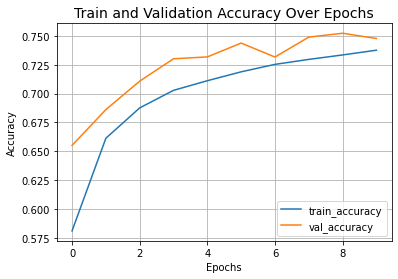

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"], label="train_accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

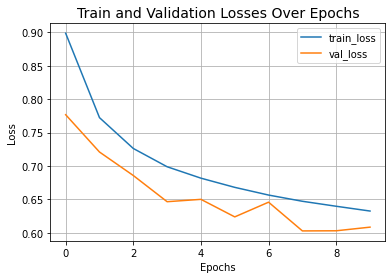

In [21]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [ ]:
loss, acc = model.evaluate([test[0], test[1]], test[2], batch_size=BATCH_SIZE)
print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss, acc))